# Nonlinear Least Squares Fit

## Example - Impedance Spectrum Model

![Tissue RC model](./drawingsImages/tissueRCmodel.png)

We have a model for the impedance for the circuit shown. Our goal is to fit data to this model to find key parameters.

$$\frac{Z}{R_1}=\frac{1+j\frac{\omega}{\omega_c}\frac{1}{1+\frac{R_1}{R_2}}}{1+j\frac{\omega}{\omega_c}} = \frac{\left[1+\left(\frac{\omega}{\omega_c}\right)^2\frac{1}{1+\frac{R_1}{R_2}}\right]-j\left[\frac{\omega}{\omega_c}\frac{\frac{R1}{R2}}{1+\frac{R1}{R2}}\right]}{1+\left(\frac{\omega}{\omega_c}\right)^2}.$$

where $R_1$ is the DC (zero frequency) resistance of the sample and

$$\omega_c \equiv \frac{1}{(R_1+R_2)C_2}.$$

Let's rewrite the inmpedance in a convenient for by defining

$$ r \equiv \frac{R_1}{R_2} $$

$$ \tau = \frac{1}{\omega_c}$$

and

$$f = \frac{\omega}{2\pi}.$$

$$\frac{Z}{R_1}=\frac{1+j2\pi f\tau\frac{1}{1+r}}{1+j2\pi f\tau}.$$

Then the magnitude is given by

$$\frac{|Z|}{R_1} = \sqrt{\frac{1+(2 \pi f\tau)^2\frac{1}{(1+r)^2}}{1+(2 \pi f\tau)^2}}.$$

Note that the normalization by $R_1$ has a deeper purpose: when modeling materials like biological tissues, the normalization should account for size effects. A hypothesis is that the remaining parameters of the model, $r$ and $\tau$, are intrinsic characteristics independent of size. (This is something to be tested.)

The following code will fit data to the moddel to find estimates of the parameters $r$ and $\tau$ given a separately measured value for $R_1$, the DC resistance. (A section of the code synthesizes some randomized data to test the fitting, but the data arrays for frequency $f$ and normalized impedance magnitude $z \equiv |Z|/R_1$ can be used instead.

The key to doing the fit is the library function curve_fit. It is strongly recommended to go read the documentation at

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

and to find further readings on nonlinear least squares methods, e.g. at

https://en.wikipedia.org/wiki/Non-linear_least_squares

Randall Tagg 2024-03-25 23:54:54 

rguess = 9.0  tauguess = 3.979e-05 s
rfit = 10.603  taufit = 2.869e-05 s   fcfit = 5.548e+03 Hz
R1 = 220.0 ohms    R2fit = 20.7 ohms   Cfit = 1.192e-07 F


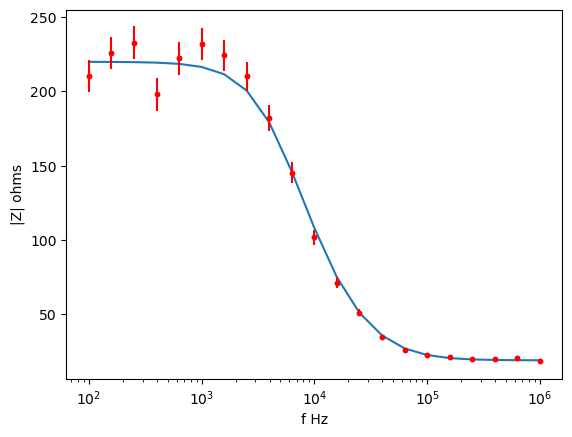

[0.9998388  0.99959523 0.9989842  0.99745433 0.99364259 0.98425928
 0.96182514 0.91166962 0.81401596 0.66348695 0.49094814 0.34025604
 0.23150404 0.16228349 0.12264668 0.10233691 0.09296196 0.08894457
 0.08729207 0.08662515 0.08635816]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import math
import datetime 

# Create a time stamp for each run
my_name = "Randall Tagg"
time_stamp_format = "%Y-%m-%d %H:%M:%S"
print(my_name,datetime.datetime.now().strftime(time_stamp_format),'\n')

# Define the model function to be fit to find parameters r and tau
def zfunc(ff,rr,tautau): #operates on an array of frequency values ff
    ft2 = (2*math.pi*ff*tautau)**2
    zz = np.sqrt((1+ft2/(1+rr)**2)/(1+ft2))
    return zz # returns an array of impedance magnitudes

#***************** Construct synthetic data arrays **********************
# This section can be replaced with actual data including a value for DC recistance R1#

r = 10.0
tau = 30.0E-6
R1 = 220
zsigma_rel = 0.05 # relative uncertainty in impedance measurement

fbase = 100 #Hz 
N = 5 # samples per decade of relative parameter murel = (mu-muc)/muc
D = 4 # number of decades
Ndata = D*N+1

# frequency data - indpendent variable
f = np.zeros(Ndata)
f[0] = fbase
multiplier = 10**(1./N)
for i in range(1,Ndata):
    f[i] = f[i-1]*multiplier

# normalized impedance data (impedance divided by DC resistance R1)
zexact = zfunc(f, r, tau) 
zsigma = zsigma_rel*zexact
z = np.random.normal(zexact, zsigma, Ndata) # create some random variation

#Alternate method to generate synthetic values of z that does not use array operations
'''
zexact = np.zeros(Ndata)
#zsigma = np.zeros(Ndata)
#z = np.zeros(Ndata)

for i in range(0,Ndata):
    #ft2 = (2*math.pi*f[i]*tau)**2
    #zexact[i] = math.sqrt((1+ft2/(1+r)**2)/(1+ft2))
    zexact[i]=zfunc(f[i],r,tau)
    zsigma[i] = zsigma_rel*zexact[i]
    z[i] = np.random.normal(zexact[i], zsigma[i], 1) # generate random variation
'''
#***************** End of synthetic data section **********************

# Do nonlinear least squares fit; so far, there is not any use of uncertainties
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

rguess = 9. # guess of ratio of DC resistance R1 to capacitive path resistance R2
fcguess = 4E3 # guess of critical frequency in Hz
tauguess = 1/(2*math.pi*fcguess)
print('rguess = {0:.1f}  tauguess = {1:.3e} s'.format(rguess,tauguess))

popt, pcov = curve_fit(zfunc,f,z,p0=[rguess,tauguess])
rfit = popt[0]
taufit = popt[1]

print('rfit = {0:.3f}  taufit = {1:.3e} s   fcfit = {2:.3e} Hz'
      .format(rfit,taufit,1/(2*math.pi*taufit)))
print('R1 = {0:.1f} ohms    R2fit = {1:.1f} ohms   Cfit = {2:.3e} F'
      .format(R1,R1/rfit,taufit/(R1*(1+1/rfit))))
zfit = zfunc(f,rfit,taufit)

# Plot data and fit

plt.plot(f,z*R1,'r.',f,zfit*R1)
plt.xscale('log')
plt.errorbar(f,z*R1,yerr=zsigma*R1,fmt='r.')
plt.xlabel('f Hz')
plt.ylabel('|Z| ohms')
plt.show()

print(zfit)